In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path

from os.path import join, isfile
from os import path, scandir, listdir

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils.extmath import softmax
from sklearn.naive_bayes import GaussianNB

#import lightgbm as lgb
#import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'target'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 5
    N_ESTIMATORS = 20000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-oct-2021")

train = pd.DataFrame(pd.read_csv(INPUT / "train.csv")[target])
#test = pd.read_csv(INPUT / "test.csv")
test = pd.DataFrame()
submission = pd.read_csv(INPUT / "sample_submission.csv")

In [5]:
def list_all_files(location='../input/tps-oct-lv0', pattern=None, recursive=True):
    """
    This function returns a list of files at a given location (including subfolders)
    
    - location: path to the directory to be searched
    - pattern: part of the file name to be searched (ex. pattern='.csv' would return all the csv files)
    - recursive: boolean, if True the function calls itself for every subdirectory it finds
    """
    subdirectories= [f.path for f in scandir(location) if f.is_dir()]
    files = [join(location, f) for f in listdir(location) if isfile(join(location, f))]
    if recursive:
        for directory in subdirectories:
            files.extend(list_all_files(directory))
    if pattern:
        files = [f for f in files if pattern in f]
    return files

In [6]:
list_all_files(pattern='kosta')[1:6]  # printing only 5 files for simplicity

['../input/tps-oct-lv0/2019_xgb_kosta_oof.npy',
 '../input/tps-oct-lv0/2020xgb_kosta_pred.npy',
 '../input/tps-oct-lv0/2020xgb_kosta_oof.npy',
 '../input/tps-oct-lv0/2017xgb_kosta_pred.npy',
 '../input/tps-oct-lv0/2021xgb_kosta_oof.npy']

In [7]:
names = ['bizen', 'henke', 'hamza', '28smiles','kashif', 'kosta', 'kaveh', 'dlaststark', 'pca', 'xgb2']

In [8]:
pred = list_all_files(pattern='oof')


for i in range(len(names)):
    avv = []
    
    for file in pred:
        if names[i] in file.split('/')[3]:
            avv.append(np.load(file))
    train[names[i]] = np.mean(avv, axis=0)
            
    
train.columns

Index(['target', 'bizen', 'henke', 'hamza', '28smiles', 'kashif', 'kosta',
       'kaveh', 'dlaststark', 'pca', 'xgb2'],
      dtype='object')

In [9]:
pred = list_all_files(pattern='pred')


for i in range(len(names)):
    avv = []
    
    for file in pred:
        if names[i] in file.split('/')[3]:
            avv.append(np.load(file))
    test[names[i]] = np.mean(avv, axis=0)
            
    
test.columns

Index(['bizen', 'henke', 'hamza', '28smiles', 'kashif', 'kosta', 'kaveh',
       'dlaststark', 'pca', 'xgb2'],
      dtype='object')

In [10]:
avv = []
for i in range(5):
    avv.append(np.load("../input/tps-oct-lv0/"+str(i+2017)+"lgb_oof.npy"))
train['lgb'] = np.mean(avv, axis=0)

avv = []
for i in range(5):
    avv.append(np.load("../input/tps-oct-lv0/"+str(i+2017)+"lgb_pred.npy"))
test['lgb']  = np.mean(avv, axis=0)

avv = []
for i in range(5):
    avv.append(np.load("../input/tps-oct-lv0/agg"+str(i+1)+"_xgb_oof.npy"))
train['xgb'] = np.mean(avv, axis=0)

avv = []
for i in range(5):
   avv.append(np.load("../input/tps-oct-lv0/agg"+str(i+1)+"_xgb_pred.npy"))
test['xgb']  = np.mean(avv, axis=0)


In [11]:
train

,target,bizen,henke,hamza,28smiles,kashif,kosta,kaveh,dlaststark,pca,xgb2,lgb,xgb
0,1,0.674985,0.666010,0.678011,0.680104,0.652988,0.675312,0.690708,0.664937,0.682232,0.649308,0.664578,0.678152
1,1,0.177265,0.181614,0.179693,0.188732,0.186017,0.177870,0.185734,0.182559,0.191858,0.185467,0.182454,0.172633
2,1,0.851934,0.864432,0.845848,0.867721,0.861763,0.857833,0.864604,0.852598,0.863318,0.848047,0.848057,0.845136
3,1,0.522808,0.520710,0.510819,0.498515,0.514420,0.515924,0.508564,0.499530,0.508041,0.520932,0.512398,0.510480
4,1,0.830692,0.824967,0.825318,0.824452,0.829991,0.823126,0.824800,0.829986,0.819209,0.833055,0.836516,0.830660
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1,0.743018,0.740781,0.767242,0.761768,0.745886,0.763393,0.775154,0.783477,0.772495,0.738084,0.749850,0.774398
999996,0,0.111363,0.112878,0.118867,0.103750,0.117746,0.121220,0.119116,0.125934,0.121002,0.125654,0.129909,0.126902
999997,0,0.179473,0.184739,0.183225,0.180549,0.173543,0.169896,0.164167,0.164623,0.163076,0.182527,0.170076,0.166062
999998,1,0.927255,0.931066,0.906244,0.931488,0.904055,0.913194,0.910379,0.899676,0.912160,0.911335,0.904151,0.905280


In [12]:
test

,bizen,henke,hamza,28smiles,kashif,kosta,kaveh,dlaststark,pca,xgb2,lgb,xgb
0,0.728526,0.722509,0.752387,0.705870,0.727055,0.735858,0.740599,0.745366,0.736168,0.731839,0.737219,0.748278
1,0.243854,0.245698,0.242451,0.235202,0.233988,0.240009,0.249772,0.248024,0.250602,0.235529,0.230626,0.233039
2,0.913063,0.912550,0.909911,0.919106,0.906819,0.910741,0.907417,0.903758,0.906905,0.906797,0.904611,0.901715
3,0.835983,0.832255,0.853693,0.817317,0.834168,0.835611,0.856448,0.843686,0.855629,0.838438,0.848851,0.853474
4,0.269920,0.276108,0.249503,0.270417,0.256404,0.265450,0.266382,0.268529,0.263090,0.260674,0.255942,0.262485
...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.975451,0.975318,0.968899,0.976103,0.966070,0.970023,0.970539,0.963713,0.970643,0.968542,0.965190,0.966362
499996,0.839360,0.841742,0.827404,0.850740,0.839601,0.834818,0.830072,0.828243,0.830860,0.830597,0.830506,0.830808
499997,0.293532,0.286726,0.299620,0.300556,0.289637,0.286823,0.284007,0.290569,0.284187,0.299252,0.288725,0.289752
499998,0.513656,0.505806,0.499243,0.526598,0.517690,0.512041,0.488363,0.496002,0.487719,0.531208,0.506413,0.505003


# Preprocessing

In [13]:
features = test.columns
#features = [col for col in train.columns if 'pred' in col]

In [14]:
ss = StandardScaler()

In [15]:
test[features]

,bizen,henke,hamza,28smiles,kashif,kosta,kaveh,dlaststark,pca,xgb2,lgb,xgb
0,0.728526,0.722509,0.752387,0.705870,0.727055,0.735858,0.740599,0.745366,0.736168,0.731839,0.737219,0.748278
1,0.243854,0.245698,0.242451,0.235202,0.233988,0.240009,0.249772,0.248024,0.250602,0.235529,0.230626,0.233039
2,0.913063,0.912550,0.909911,0.919106,0.906819,0.910741,0.907417,0.903758,0.906905,0.906797,0.904611,0.901715
3,0.835983,0.832255,0.853693,0.817317,0.834168,0.835611,0.856448,0.843686,0.855629,0.838438,0.848851,0.853474
4,0.269920,0.276108,0.249503,0.270417,0.256404,0.265450,0.266382,0.268529,0.263090,0.260674,0.255942,0.262485
...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.975451,0.975318,0.968899,0.976103,0.966070,0.970023,0.970539,0.963713,0.970643,0.968542,0.965190,0.966362
499996,0.839360,0.841742,0.827404,0.850740,0.839601,0.834818,0.830072,0.828243,0.830860,0.830597,0.830506,0.830808
499997,0.293532,0.286726,0.299620,0.300556,0.289637,0.286823,0.284007,0.290569,0.284187,0.299252,0.288725,0.289752
499998,0.513656,0.505806,0.499243,0.526598,0.517690,0.512041,0.488363,0.496002,0.487719,0.531208,0.506413,0.505003


In [16]:
train[target]

0         1
1         1
2         1
3         1
4         1
         ..
999995    1
999996    0
999997    0
999998    1
999999    0
Name: target, Length: 1000000, dtype: int64

# GNB

In [17]:
gnb_params = {
                'var_smoothing': 0.10739307163234939
}

In [18]:
gnb_oof = np.zeros(train.shape[0])
gnb_pred = np.zeros(test.shape[0])
gnb_importances = pd.DataFrame()


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=range(SEED, SEED+20)

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")


    X_train = train[features].iloc[trn_idx]
    y_train = train[target].iloc[trn_idx]
    X_valid = train[features].iloc[val_idx]
    y_valid = train[target].iloc[val_idx]
    X_test = test[features]

        
    X_train[features] = ss.fit_transform(X_train[features])
    X_valid[features] = ss.transform(X_valid[features])
    X_test[features] = ss.transform(X_test[features])

    start = time.time()
    for inseed in seed_list:
        #gnb_params['random_state'] = inseed

        model = GaussianNB(**gnb_params)
        model.fit(
            X_train, 
            y_train,
            
        )

        with open(f"gnb_model{fold}_seed{inseed}.pkl", 'wb') as f:
            pickle.dump(model, f)


        gnb_oof[val_idx] += model.predict_proba(X_valid)[:,-1] / len(seed_list)
        gnb_pred += model.predict_proba(X_test)[:,-1] / len(seed_list)


    elapsed = time.time() - start
    auc = roc_auc_score(y_valid, gnb_oof[val_idx])
    print(f"fold {fold} - gnb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")            

gnb_pred /= N_SPLITS
print(f"oof gnb_auc = {roc_auc_score(train[target], gnb_oof)}")

np.save("gnb_oof.npy", gnb_oof)
np.save("gnb_pred.npy", gnb_pred)

===== fold 0 =====
fold 0 - gnb auc: 0.856615, elapsed time: 7.92sec

===== fold 1 =====
fold 1 - gnb auc: 0.857907, elapsed time: 7.94sec

===== fold 2 =====
fold 2 - gnb auc: 0.858440, elapsed time: 7.93sec

===== fold 3 =====
fold 3 - gnb auc: 0.856892, elapsed time: 7.98sec

===== fold 4 =====
fold 4 - gnb auc: 0.856808, elapsed time: 7.99sec

oof gnb_auc = 0.8573308141165631


# OOF predictions

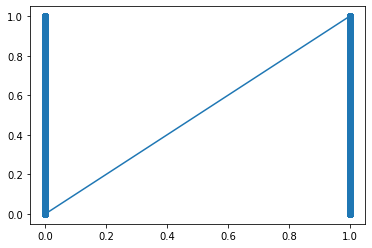

In [19]:
plt.plot(train[target], train[target])
plt.scatter(train[target], gnb_oof)

# Submission

In [20]:
submission[target] = gnb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,target
0,1000000,9.999999e-01
1,1000001,5.476935e-08
2,1000002,1.000000e+00
3,1000003,1.000000e+00
4,1000004,2.060277e-07
...,...,...
499995,1499995,1.000000e+00
499996,1499996,1.000000e+00
499997,1499997,1.024979e-06
499998,1499998,4.700489e-01


# Log

/////// best /////////

ver1 average
